In [8]:
from pathlib import Path

ROOT = Path.cwd()
while not (ROOT / "data").exists() and ROOT != ROOT.parent:
    ROOT = ROOT.parent

DATA = ROOT / "data"
print("Project root:", ROOT)
print("Data dir ok?:", DATA.exists())


print("08_reporting CSVs:", list((DATA / "08_reporting").glob("*.csv")))
print("07_model_output CSVs:", list((DATA / "07_model_output").glob("*.csv")))


Project root: C:\ML\spaceflights
Data dir ok?: True
08_reporting CSVs: [WindowsPath('C:/ML/spaceflights/data/08_reporting/clf_results_table.csv'), WindowsPath('C:/ML/spaceflights/data/08_reporting/final_classification_report.csv'), WindowsPath('C:/ML/spaceflights/data/08_reporting/final_confusion_matrix.csv'), WindowsPath('C:/ML/spaceflights/data/08_reporting/final_eval_metrics.csv'), WindowsPath('C:/ML/spaceflights/data/08_reporting/final_roc_curve.csv'), WindowsPath('C:/ML/spaceflights/data/08_reporting/pca_kmeans_report.csv'), WindowsPath('C:/ML/spaceflights/data/08_reporting/report_meteorites_summary.csv'), WindowsPath('C:/ML/spaceflights/data/08_reporting/report_neo_summary.csv')]
07_model_output CSVs: [WindowsPath('C:/ML/spaceflights/data/07_model_output/eval_metrics.csv')]


In [9]:
import pandas as pd

def pick_first(*paths):
    for p in paths:
        if p.exists():
            return p
    raise FileNotFoundError("No encontré ninguno de:\n- " + "\n- ".join(map(str, paths)))

path_leader  = pick_first(
    DATA / "08_reporting" / "clf_results_table.csv",
    DATA / "07_model_output" / "eval_metrics.csv",  # por si cambió el nombre
)

path_roc     = pick_first(
    DATA / "08_reporting" / "final_roc_curve.csv",
    DATA / "07_model_output" / "final_roc_curve.csv",
)

path_conf    = pick_first(
    DATA / "08_reporting" / "final_confusion_matrix.csv",
    DATA / "07_model_output" / "final_confusion_matrix.csv",
)

path_metrics = pick_first(
    DATA / "08_reporting" / "final_eval_metrics.csv",
    DATA / "07_model_output" / "final_eval_metrics.csv",
)

clf_results  = pd.read_csv(path_leader)
roc_curve_df = pd.read_csv(path_roc)
confusion_df = pd.read_csv(path_conf)
metrics_df   = pd.read_csv(path_metrics)

clf_results.head()


,f1,recall,precision,roc_auc
0,0.468433,0.940045,0.311937,0.883436


In [17]:
import os
import pandas as pd

OUT_DIR = DATA / "08_reporting"
OUT_DIR.mkdir(parents=True, exist_ok=True)

sort_cols = [c for c in ["cv_best_score", "f1"] if c in clf_results.columns]
ascending = [False] * len(sort_cols)

top_n = 10  # cambia si quieres
top_table = clf_results.sort_values(sort_cols, ascending=ascending).head(top_n)

display(top_table)

#resumen lindoo
top_path = OUT_DIR / "top_models_summary.csv"
top_table.to_csv(top_path, index=False)
print("Top-N guardado en:", top_path)


,f1,recall,precision,roc_auc
0,0.468433,0.940045,0.311937,0.883436


Top-N guardado en: C:\ML\spaceflights\notebooks\08_reporting\data\08_reporting\top_models_summary.csv


Matriz de confusión guardada en: C:\ML\spaceflights\notebooks\08_reporting\data\08_reporting\confusion_matrix.png


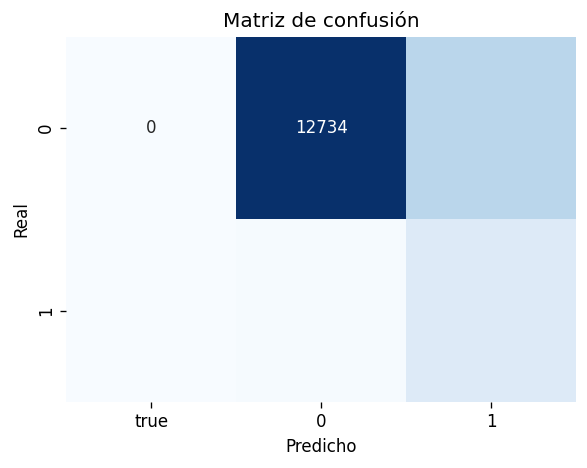

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
sns.heatmap(
    confusion_df,
    annot=True, fmt="d", cmap="Blues",
    cbar=False, ax=ax
)
ax.set_title("Matriz de confusión")
ax.set_xlabel("Predicho")
ax.set_ylabel("Real")
plt.tight_layout()

cm_path = OUT_DIR / "confusion_matrix.png"
plt.savefig(cm_path, bbox_inches="tight")
print("Matriz de confusión guardada en:", cm_path)
plt.show()


Curva ROC guardada en: C:\ML\spaceflights\notebooks\08_reporting\data\08_reporting\roc_curve.png


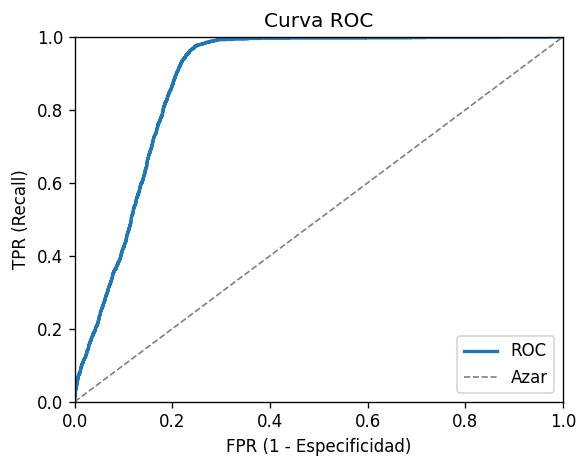

In [19]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=120)
ax.plot(roc_curve_df["fpr"], roc_curve_df["tpr"], lw=2, label="ROC")
ax.plot([0, 1], [0, 1], "--", lw=1, color="gray", label="Azar")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("FPR (1 - Especificidad)")
ax.set_ylabel("TPR (Recall)")
ax.set_title("Curva ROC")
ax.legend()
plt.tight_layout()

roc_path = OUT_DIR / "roc_curve.png"
plt.savefig(roc_path, bbox_inches="tight")
print("Curva ROC guardada en:", roc_path)
plt.show()


Barras de métricas guardadas en: C:\ML\spaceflights\notebooks\08_reporting\data\08_reporting\final_metrics_bars.png


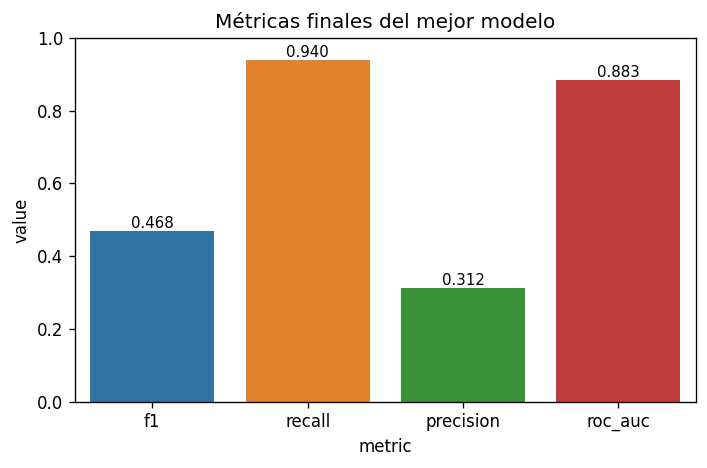

In [20]:
mcols = ["f1", "recall", "precision", "roc_auc"]
available = [c for c in mcols if c in metrics_df.columns]
plot_df = metrics_df[available].T.reset_index()
plot_df.columns = ["metric", "value"]

fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
sns.barplot(data=plot_df, x="metric", y="value", ax=ax)
ax.set_ylim(0, 1)
ax.set_title("Métricas finales del mejor modelo")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.3f}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha="center", va="bottom", fontsize=9)
plt.tight_layout()

bars_path = OUT_DIR / "final_metrics_bars.png"
plt.savefig(bars_path, bbox_inches="tight")
print("Barras de métricas guardadas en:", bars_path)
plt.show()


In [21]:
cols = [c for c in ["model","cv_best_score","f1","recall","precision","roc_auc","best_params"] if c in clf_results.columns]
leaderboard = clf_results[cols].sort_values([c for c in ["cv_best_score","f1"] if c in cols], ascending=False)
display(leaderboard.head(20))

lb_path = OUT_DIR / "leaderboard_clean.csv"
leaderboard.to_csv(lb_path, index=False)
print("Leaderboard guardado en:", lb_path)


,f1,recall,precision,roc_auc
0,0.468433,0.940045,0.311937,0.883436


Leaderboard guardado en: C:\ML\spaceflights\notebooks\08_reporting\data\08_reporting\leaderboard_clean.csv
